<a href="https://colab.research.google.com/github/Amna1701/alfaisalx-medmnist-challenge/blob/main/notebooks/AlfaisalX_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 – CNN Classification on PneumoniaMNIST

This notebook implements a lightweight convolutional neural network (CNN)
for binary classification of chest X-ray images (Normal vs Pneumonia)
using the MedMNIST v2 PneumoniaMNIST dataset.

The implementation runs on CPU and reproduces evaluation metrics,
saves training curves, confusion matrix, ROC curve, failure cases,
and Grad-CAM visualizations under:

reports/task1/

## Environment Setup

In [1]:
!pip -q install --upgrade pip
!pip -q uninstall -y numpy pandas scikit-learn scikit-image medmnist || true
!pip -q install "numpy==1.26.4" "pillow==10.4.0"
!pip -q install "torch" "torchvision" --index-url https://download.pytorch.org/whl/cu121
!pip -q install "medmnist==2.2.3" "scikit-learn==1.3.2" "tqdm" "matplotlib" "seaborn"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 3.7.3 requires pandas>=1.2, which is not installed.
pointpats 2.5.2 requires pandas!=1.5.0,>=1.4, which is not installed.
holoviews 1.22.1 requires pandas>=1.3, which is not installed.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
librosa 0.11.0 requires scikit-learn>=1.1.0, which is not installed.
shap 0.50.0 requires pandas, which is not installed.
shap 0.50.0 requires scikit-learn, which is not installed.
esda 2.8.1 requires pandas>=2.1, which is not installed.
esda 2.8.1 requires scikit-learn>=1.4, which is not installed.
dask-cuda 25.10.0 requires pandas>=1.3, which is not installed.
yfinance 0.2.66 requires pandas>=1.3.0, which is not installed.
bigframes 2.35.0 requires pandas>=1.5.3, which is not installed.
cmdstanpy 1.3.0 requires pandas, which is not installed.
sklearn-panda

In [2]:
import numpy as np
import torch
from medmnist import PneumoniaMNIST
from torchvision import transforms
print("OK", np.__version__, torch.__version__)

OK 1.26.4 2.10.0+cu128


In [3]:
import numpy, PIL, transformers, medmnist, torch
print("numpy", numpy.__version__)
print("pillow", PIL.__version__)
print("transformers", transformers.__version__)
print("medmnist", medmnist.__version__)
print("torch", torch.__version__)

numpy 1.26.4
pillow 10.4.0
transformers 5.0.0
medmnist 2.2.3
torch 2.10.0+cu128


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from medmnist import PneumoniaMNIST
from torchvision import transforms

# Basic transforms (no augmentation yet)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load splits
train_ds = PneumoniaMNIST(split="train", download=True, transform=transform)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=transform)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=transform)

print("Train:", len(train_ds), " Val:", len(val_ds), " Test:", len(test_ds))
print("Example item shapes:")
x, y = train_ds[0]
print("Image tensor shape:", x.shape, " Label:", y, " Label type:", type(y))

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.41MB/s]


Train: 4708  Val: 524  Test: 624
Example item shapes:
Image tensor shape: torch.Size([1, 28, 28])  Label: [1]  Label type: <class 'numpy.ndarray'>


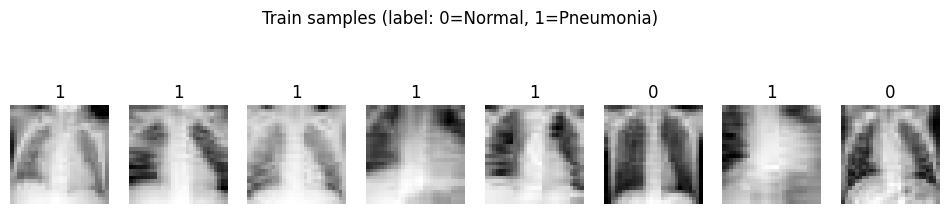

In [8]:
def show_samples(dataset, n=8, title="Samples"):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        x, y = dataset[i]
        img = x.squeeze(0).numpy()  # (28,28)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(int(y[0]))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, n=8, title="Train samples (label: 0=Normal, 1=Pneumonia)")

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = PneumoniaMNIST(split="train", download=True, transform=train_tf)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=test_tf)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=test_tf)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(37, 5, 5)

In [12]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)  # output logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)  # (B,)

model = SmallCNN().to(device)
print(model)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def run_train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)  # (B,)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def run_val_epoch(model, loader):
    model.eval()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

epochs = 15
train_losses, val_losses = [], []
best_val = float("inf")
best_path = "best_model_task1.pt"

for epoch in range(1, epochs+1):
    tr_loss = run_train_epoch(model, train_loader)
    va_loss = run_val_epoch(model, val_loader)
    scheduler.step(va_loss)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), best_path)

print("Best model saved to:", best_path, "best_val_loss:", best_val)

  0%|          | 0/37 [00:00<?, ?it/s]/tmp/ipython-input-2846689616.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)  # (B,)
/tmp/ipython-input-2846689616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)


Epoch 01 | train_loss=0.5856 | val_loss=0.5567


Epoch 02 | train_loss=0.4956 | val_loss=0.4200


Epoch 03 | train_loss=0.3744 | val_loss=0.3236


Epoch 04 | train_loss=0.2707 | val_loss=0.2800


Epoch 05 | train_loss=0.2431 | val_loss=0.2795


Epoch 06 | train_loss=0.2252 | val_loss=0.2383


Epoch 07 | train_loss=0.2234 | val_loss=0.2564


Epoch 08 | train_loss=0.2006 | val_loss=0.2033


Epoch 09 | train_loss=0.1932 | val_loss=0.2184


Epoch 10 | train_loss=0.1857 | val_loss=0.2084


Epoch 11 | train_loss=0.1750 | val_loss=0.2111


Epoch 12 | train_loss=0.1733 | val_loss=0.1844


Epoch 13 | train_loss=0.1613 | val_loss=0.1983


Epoch 14 | train_loss=0.1588 | val_loss=0.1949


Epoch 15 | train_loss=0.1662 | val_loss=0.1901
Best model saved to: best_model_task1.pt best_val_loss: 0.1844474250123701


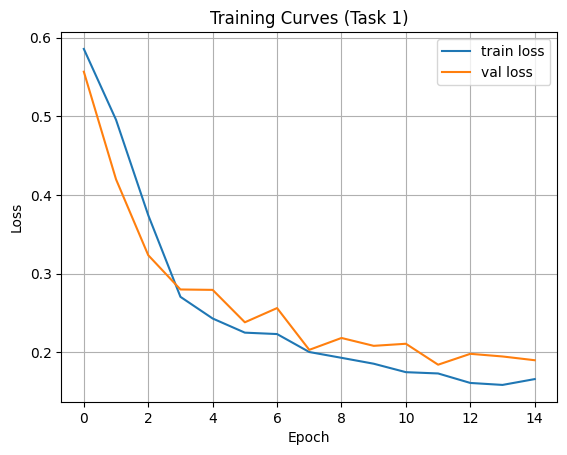

In [14]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("best_model_task1.pt"))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predictions
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("AUC      :", auc)

Accuracy : 0.8541666666666666
Precision: 0.8257080610021786
Recall   : 0.9717948717948718
F1-score : 0.8928150765606596
AUC      : 0.9423296077142231


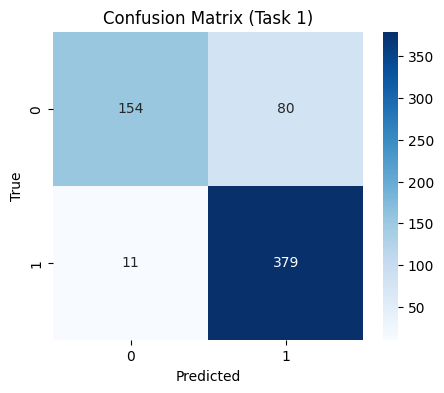

In [16]:
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.show()

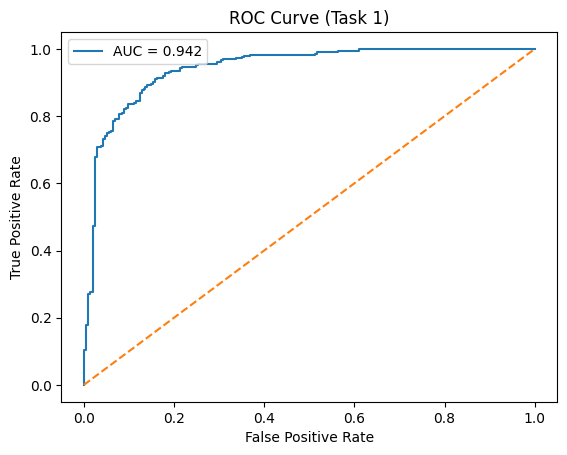

In [18]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.show()

In [19]:
wrong_indices = np.where(preds != all_labels)[0]
len(wrong_indices)

91

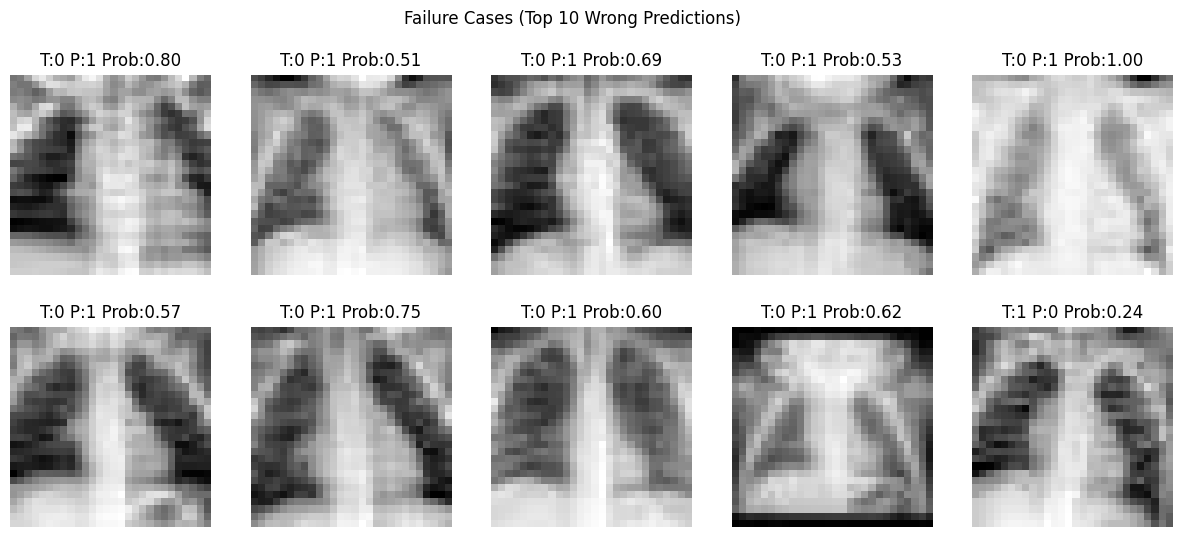

In [20]:
# Get original (non-augmented) test dataset for visualization
orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))

for i in range(10):  # show 10 wrong cases
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.show()

In [21]:
import os

os.makedirs("reports/task1", exist_ok=True)

# Save training curves
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.savefig("reports/task1/training_curves.png", dpi=300)
plt.close()

# Save confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.savefig("reports/task1/confusion_matrix.png", dpi=300)
plt.close()

# Save ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.savefig("reports/task1/roc_curve.png", dpi=300)
plt.close()

print("All figures saved in reports/task1/")

All figures saved in reports/task1/


In [22]:
import json

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "auc": float(auc)
}

with open("reports/task1/test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

metrics

{'accuracy': 0.8541666666666666,
 'precision': 0.8257080610021786,
 'recall': 0.9717948717948718,
 'f1_score': 0.8928150765606596,
 'auc': 0.9423296077142231}

In [23]:
plt.figure(figsize=(15,6))

for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()

print("Failure cases saved.")

Failure cases saved.


In [24]:
import os, shutil
os.makedirs("models", exist_ok=True)
shutil.copy("best_model_task1.pt", "models/best_model_task1.pt")
print("Saved models/best_model_task1.pt")

Saved models/best_model_task1.pt


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from medmnist import PneumoniaMNIST

orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))
for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()
    prob = all_probs[idx]
    pred = preds[idx]
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()
print("Saved reports/task1/failure_cases.png")

Saved reports/task1/failure_cases.png


In [26]:
import os
print(sorted(os.listdir("reports/task1")))

['confusion_matrix.png', 'failure_cases.png', 'roc_curve.png', 'test_metrics.json', 'training_curves.png']


In [28]:
%cd /content

!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 87 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 799.32 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [29]:
!ls

alfaisalx-medmnist-challenge  models  reports  sample_data


In [2]:
%cd /content
!ls


/content
sample_data


In [3]:
%cd /content
!pwd
!ls -la

/content
/content
total 16
drwxr-xr-x 1 root root 4096 Jan 16 14:24 .
drwxr-xr-x 1 root root 4096 Feb 22 08:23 ..
drwxr-xr-x 4 root root 4096 Jan 16 14:24 .config
drwxr-xr-x 1 root root 4096 Jan 16 14:24 sample_data


In [4]:
%cd /content
!rm -rf alfaisalx-medmnist-challenge
!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
!ls

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 87 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 799.32 KiB | 13.55 MiB/s, done.
Resolving deltas: 100% (34/34), done.
alfaisalx-medmnist-challenge  sample_data


In [5]:
%cd /content/alfaisalx-medmnist-challenge
!ls -la

/content/alfaisalx-medmnist-challenge
total 48
drwxr-xr-x 8 root root 4096 Feb 22 08:36 .
drwxr-xr-x 1 root root 4096 Feb 22 08:36 ..
drwxr-xr-x 2 root root 4096 Feb 22 08:36 data
drwxr-xr-x 8 root root 4096 Feb 22 08:36 .git
-rw-r--r-- 1 root root 4688 Feb 22 08:36 .gitignore
drwxr-xr-x 2 root root 4096 Feb 22 08:36 models
drwxr-xr-x 2 root root 4096 Feb 22 08:36 notebooks
-rw-r--r-- 1 root root 1559 Feb 22 08:36 README.md
drwxr-xr-x 3 root root 4096 Feb 22 08:36 reports
-rw-r--r-- 1 root root   69 Feb 22 08:36 requirements.txt
drwxr-xr-x 2 root root 4096 Feb 22 08:36 task3_retrieval


In [6]:
%cd /content/alfaisalx-medmnist-challenge

!mkdir -p models reports
!cp -r /content/models/* models/ 2>/dev/null || echo "No /content/models found"
!cp -r /content/reports/* reports/ 2>/dev/null || echo "No /content/reports found"

!find reports -maxdepth 2 -type f
!find models -maxdepth 2 -type f

/content/alfaisalx-medmnist-challenge
No /content/models found
No /content/reports found
reports/confusion_matrix.png
reports/task1_classification_report.md
reports/failure_cases.png
reports/roc_curve.png
models/best_model_task1.pt


In [7]:
%cd /content/alfaisalx-medmnist-challenge
!git add -A
!git status
!git commit -m "Add Task1 outputs (reports + model)" || echo "Nothing to commit"

/content/alfaisalx-medmnist-challenge
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@7e402d975808.(none)')
Nothing to commit


In [8]:
%cd /content/alfaisalx-medmnist-challenge

!git config --global user.name "Amna1701"
!git config --global user.email "2018024900@chd.edu.cn"

/content/alfaisalx-medmnist-challenge


In [9]:
!git config --global --list

user.name=Amna1701
user.email=2018024900@chd.edu.cn


In [11]:
%cd /content/alfaisalx-medmnist-challenge
!pwd
!ls

/content/alfaisalx-medmnist-challenge
/content/alfaisalx-medmnist-challenge
data  models  notebooks  README.md  reports  requirements.txt  task3_retrieval


In [12]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [16]:
%cd /content/alfaisalx-medmnist-challenge
!ls reports/task1
!ls models

/content/alfaisalx-medmnist-challenge
ls: cannot access 'reports/task1': No such file or directory
best_model_task1.pt
